In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
sys.path.append("../src")

In [3]:
import tensorflow as tf
from tensorflow.keras import layers as ll
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob

from src.data.tab import type_map, unusable_types
import pandas as pd

In [5]:
filelist = glob.glob("/Volumes/WD-MKAIROV/for_Soroosh/Normalized_brains/*/wT1_acpc_*.nii")
filelist = sorted([f.replace("__", "_") for f in filelist], key=lambda f: int(f.split("_")[-1].split(".")[0]))

In [16]:
import pandas as pd

demo = pd.read_excel("../data/demo.xlsx")
demo = demo[demo["ID"].isin([int(f.split("_")[-1].split(".")[0]) for f in filelist])]
demo = demo[~demo["Aphasia Type"].isin(unusable_types)]
# filelist2 = [f for f in filelist if int(f.split("_")[-1].split(".")[0]) in demo["ID"]]

types = demo["Aphasia Type"].map(type_map).to_numpy()

In [22]:
mri_ids = list(set(demo["ID"].values) & set([int(f.split("_")[-1].split(".")[0]) for f in filelist]))

In [45]:
def get_file_np(i):
    filename = list(filter(lambda f: int(f.split("_")[-1].split(".")[0]) == mri_ids[i], filelist))[0]
    # filename = glob.glob(f"/Volumes/WD-MKAIROV/for_Soroosh/Normalized_brains/*/wT1_acpc_{mri_id}*.nii")
    return np.nan_to_num(np.array(nib.load(filename).dataobj))

In [46]:
X = np.empty((50, 182, 218, 182))
for i in range(50):
    X[i, ...] = get_file_np(i)

In [60]:
X = tf.expand_dims(X, axis=-1)
train_loader = tf.data.Dataset.from_tensor_slices((X, types[:50]))

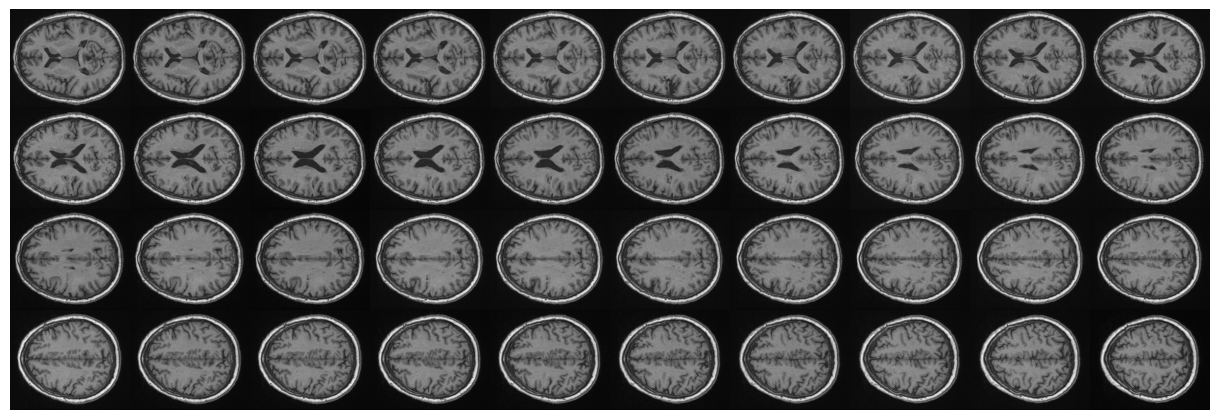

In [49]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 182, 218, X[15, :, :, 80:120])

In [6]:
import keras
from keras import layers

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=182, height=218, depth=182)
model.summary()

Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 182, 218, 182,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 180, 216, 180,  │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 90, 108, 90,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 108, 90,    │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 88, 106, 88,    │       110,656 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 44, 53, 44, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 44, 53, 44, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 42, 51, 42,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 21, 25, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 21, 25, 21,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 19, 23, 19,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 9, 11, 9, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 9, 11, 9, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
def m2tex(model,modelName):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: {} \\\\ \hline".format(modelName)
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] += " \hline"
    stringlist[-3] += " \\\\"
    stringlist[-2] += " \\\\"
    stringlist[-1] += " \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{{Model summary for {}.}}".format(modelName), "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

m2tex(model, "3D CNN")

['Model: "3dcnn"\n┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓\n┃ Layer (type)                 ┃ Output Shape          ┃     Param # ┃\n┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩\n│ input_layer_1 (InputLayer)   │ (None, 182, 218, 182, │           0 │\n│                              │ 1)                    │             │\n├──────────────────────────────┼───────────────────────┼─────────────┤\n│ conv3d_4 (Conv3D)            │ (None, 180, 216, 180, │       1,792 │\n│                              │ 64)                   │             │\n├──────────────────────────────┼───────────────────────┼─────────────┤\n│ max_pooling3d_4              │ (None, 90, 108, 90,   │           0 │\n│ (MaxPooling3D)               │ 64)                   │             │\n├──────────────────────────────┼───────────────────────┼─────────────┤\n│ batch_normalization_4        │ (None, 90, 108, 90,   │         256 │\n│ (BatchNormalization)         │ 64)          

IndexError: list assignment index out of range

In [61]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

epochs = 5
model.fit(
    train_loader,
    # validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    # callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5


ValueError: Input 0 of layer "3dcnn" is incompatible with the layer: expected shape=(None, 182, 218, 182, 1), found shape=(182, 218, 182, 1)